In [1]:
import numpy as np
import pandas as pd
import json
import codecs
import datetime
import os
import sys

In [2]:
sys.path.append('.')

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt


In [4]:
import oci
import json
from oci.config import validate_config

In [5]:
tenancyId="ocid1.tenancy.oc1..aaaaaaaahkzl4rzvgxjfnrfcj7rzlsdav25h7tsx7kjxyv2bmwkfpzpag26q" # Your tenancies OCID.
authUserId="ocid1.user.oc1..aaaaaaaayltryoz33ole5eubwphwijkcvmi4ukbombh4aym2crp5j6xqxaxq" # The OCID of the user ID being used.
OCI_KEY_PATH="/home/datascience/.oci/oci_api_key.pem" # Path of the key file.
keyFingerprint="9a:47:38:96:c8:4d:bf:7e:32:3d:7c:c3:24:23:71:35" # The fingerprint of the key file being used
namespace = "lrzustouvvrg"
bucket_name = "sdk-initial-data-bucket"
config = {
    "user": authUserId,
    "key_file": OCI_KEY_PATH,
    "fingerprint": keyFingerprint,
    "tenancy": tenancyId,
    "region": "uk-london-1"
}

In [6]:
validate_config(config)

In [7]:
object_storage_client = oci.object_storage.ObjectStorageClient(config)
next_starts_with = None
object_list = object_storage_client.list_objects(namespace, bucket_name , fields='name, timeCreated, size', start=next_starts_with)

In [8]:
f = object_list.data.objects

In [9]:
f[0]

{
  "archival_state": null,
  "etag": null,
  "md5": null,
  "name": "005b6c49-c4ed-438b-9092-ad02ed4d672e_26-07-2021_13-36-18.json",
  "size": 530965,
  "storage_tier": null,
  "time_created": "2021-07-26T05:36:31.229000+00:00",
  "time_modified": null
}

In [10]:
object_list.data.objects[0]

{
  "archival_state": null,
  "etag": null,
  "md5": null,
  "name": "005b6c49-c4ed-438b-9092-ad02ed4d672e_26-07-2021_13-36-18.json",
  "size": 530965,
  "storage_tier": null,
  "time_created": "2021-07-26T05:36:31.229000+00:00",
  "time_modified": null
}

In [11]:
len(f)

1000

In [12]:
obj = object_storage_client.get_object(namespace, bucket_name, f[0].name).data

In [13]:
type(obj.content)

bytes

In [14]:
j_obj = json.loads(obj.content)

In [15]:
type(j_obj)

dict

In [10]:
from vector_creator.score_vectors_assembly import score_vector_from_bucket, normalize_scores

In [ ]:
res0 = score_vector_from_bucket(object_storage_client, 'photo-gallery', next_starts_with)

In [12]:
res0.to_csv('csv_files/photo_gallery_kobi_ver.csv')

In [13]:
next_starts_with = object_list.data.next_start_with

In [14]:
osc = object_storage_client.list_objects(namespace, bucket_name, start=next_starts_with, fields='name, timeCreated, size')
g = osc.data.objects
g[0]

{
  "archival_state": null,
  "etag": null,
  "md5": null,
  "name": "790cffbe-32d1-4c89-b22f-43bbdd3fe6be_13-07-2021_00-28-38.json",
  "size": 62083,
  "storage_tier": null,
  "time_created": "2021-07-12T16:26:22.891000+00:00",
  "time_modified": null
}

In [15]:
len(g)

1000

In [ ]:
res1 = score_vector_from_bucket(object_storage_client, 'photo-gallery', next_starts_with)

In [17]:
res1.to_csv('csv_files/photo_gallery_kobi_ver_2.csv')

In [18]:
res = res0.append(res1)

In [29]:
res.shape

(811, 27)

In [20]:
res.to_csv('csv_files/photo_gallery_kobi_ver_full.csv')

In [ ]:
next_starts_with = object_list.data.next_start_with

In [ ]:
osc = object_storage_client.list_objects(namespace, bucket_name, start=next_starts_with, fields='name, timeCreated, size')
g = osc.data.objects
g[0]

In [ ]:
len(g)

In [ ]:
res2 = score_vector_from_bucket(object_storage_client, 'photo-gallery', next_starts_with)

In [ ]:
res.to_csv('score_vec_photogallery_aggresive.csv')

In [42]:
res.index.is_unique

True

In [43]:
inxs = res.index.values

In [44]:
len(inxs)

811

In [30]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, MeanShift, estimate_bandwidth

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import cycle
import pandas as pd

In [32]:
def normalize_scores(df, method):
    df_scale = df.transpose()
    if len(df) > 20:
        df_scale =  z_score(df_scale) if method == 'z-score' else minmax_scale(df_scale)
    return df_scale.transpose()

In [33]:
from vector_creator.stats_models.estimators import *

In [34]:
nr = normalize_scores(res, 'min-max')

In [35]:
nz = normalize_scores(res, 'z-score')

In [36]:
type(nr)

numpy.ndarray

In [270]:
nz.shape

(811, 27)

--> Start tSNE for 2D 

In [38]:
tsne = TSNE(n_components=2, verbose=1, perplexity=50, n_iter=300, method='exact')

In [39]:
tsne_res = tsne.fit_transform(nz)

[t-SNE] Computing pairwise distances...
[t-SNE] Computed conditional probabilities for sample 811 / 811
[t-SNE] Mean sigma: 1.346275
[t-SNE] KL divergence after 250 iterations with early exaggeration: 60.814583
[t-SNE] KL divergence after 300 iterations: 0.808069


In [45]:
df = pd.DataFrame(tsne_res, columns=['x_col', 'y_col'], index=inxs)

In [46]:
df.shape

(811, 2)

In [271]:
df.head(5)

,x_col,y_col
005b6c49-c4ed-438b-9092-ad02ed4d672e,-6.445101,-9.459874
007a0785-1321-4112-be89-e6549a4725a2,-6.622664,8.609216
00e37960-250f-4185-94ac-143b319730e3,9.927461,-6.759468
025aa94c-bbf4-4e15-9ba1-7a7c18153fce,13.009322,-8.127320
03363918-9d74-4668-89bf-46ea1f05e802,0.846786,-1.998743


<AxesSubplot:xlabel='x_col', ylabel='y_col'>

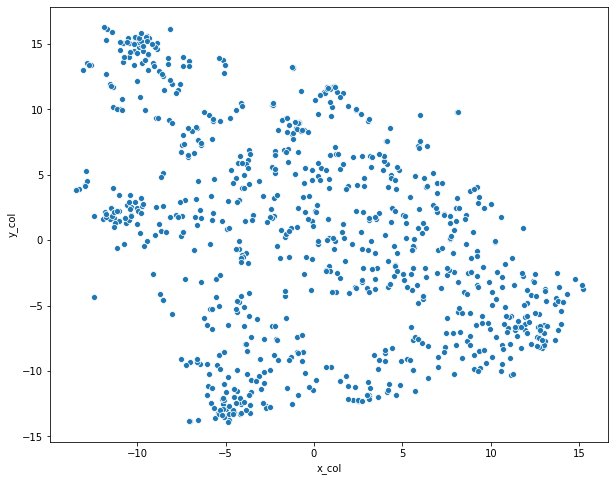

In [48]:
plt.figure(figsize=(10,8))
sns.scatterplot(
    x='x_col', 
    y='y_col',
    data=df
)

--> Mean Shift for tSNE-2D data frame

In [333]:
bandwidth = estimate_bandwidth(df, quantile=0.10)

In [334]:
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(df)

MeanShift(bandwidth=4.744894453228165, bin_seeding=True)

In [335]:
labels = ms.labels_
cluster_centers = ms.cluster_centers_
labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)

In [336]:
cluster_centers

array([[ 10.98191  ,  -6.0501146],
       [  4.809356 ,  -0.571983 ],
       [ -1.1091182,   5.059934 ],
       [ -4.0286922, -10.967394 ],
       [ -9.612223 ,  13.573589 ],
       [ -9.498581 ,   2.0001378],
       [  5.5599613,  -9.6128   ],
       [ -4.1020365,  -4.587527 ]], dtype=float32)

In [337]:
labels_unique

array([0, 1, 2, 3, 4, 5, 6, 7])

--> Plot tSNE mean-shift 2D with uids as index to df 

b [10.98191   -6.0501146] 0
g [ 4.809356 -0.571983] 1
r [-1.1091182  5.059934 ] 2
c [ -4.0286922 -10.967394 ] 3
m [-9.612223 13.573589] 4
y [-9.498581   2.0001378] 5
k [ 5.5599613 -9.6128   ] 6
b [-4.1020365 -4.587527 ] 7


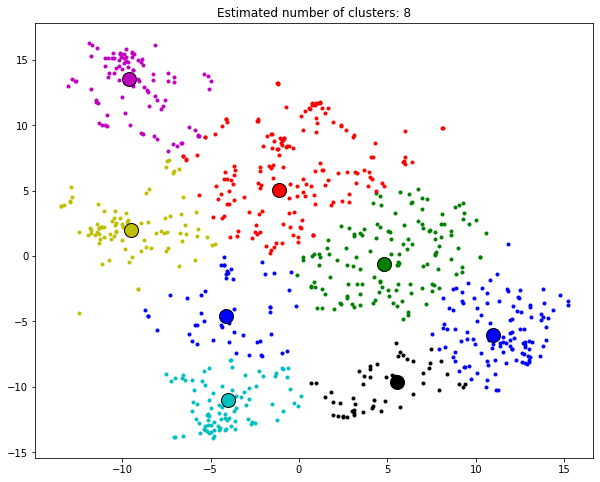

In [338]:
plt.figure(figsize=(10,8))
plt.clf()
X = df.values
colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters_), colors):
    my_members = labels == k
    print(col, cluster_centers[k], k)
    cluster_center = cluster_centers[k]
    plt.plot(X[my_members, 0], X[my_members, 1], col + '.')
    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14)
plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

In [339]:
lbls = np.unique(ms.labels_)

In [340]:
res['labels']= ms.labels_

In [341]:
res.head(5)

description,mean daily number photos,std daily number photos,huber mean daily number photos,huber std daily number photos,mean number of photos in burst,mean number of bursts a week,mean night time number photos,std night time number photos,huber mean night time number photos,huber std night time number photos,...,mean work days number photos,std work days number photos,huber mean work days number photos,huber std work days number photos,ar daily num of photos lag-1,ar daily num of photos lag-2,ar daily num of photos lag-4,entropy on photo category,entropy on daily photos,labels
005b6c49-c4ed-438b-9092-ad02ed4d672e,5.371968,11.820840,3.001997,2.406267,1.233292,2.675497,5.200000,12.277594,2.581362,1.972111,...,5.477612,12.847682,2.902985,2.301713,14.575820,14.730884,14.826054,0.077163,7.228774,3
007a0785-1321-4112-be89-e6549a4725a2,26.128205,64.759983,5.557214,5.698175,2.310658,3.230769,9.958333,20.175231,4.320968,3.919970,...,23.216667,56.811997,4.831715,4.606796,27.657266,27.783265,27.788143,0.024808,4.114481,4
00e37960-250f-4185-94ac-143b319730e3,4.944000,5.832741,4.048776,3.305434,1.152985,18.482759,2.901235,2.618099,2.506584,1.846115,...,5.287356,6.501827,4.224183,3.417475,4.890694,4.848025,4.526093,0.282838,6.318157,0
025aa94c-bbf4-4e15-9ba1-7a7c18153fce,11.486842,7.831269,11.386725,8.717991,1.310811,51.230769,7.657143,5.564905,7.374863,5.677751,...,13.037736,8.070356,12.988232,9.133273,7.515937,7.685804,7.569735,0.000000,5.882369,0
03363918-9d74-4668-89bf-46ea1f05e802,3.669516,3.890841,2.989229,2.143765,1.260274,2.328018,2.966942,3.436397,2.396525,1.628969,...,3.609053,3.288501,3.019313,2.118362,1.098323,1.090561,0.973541,0.110858,7.913938,1


In [348]:
def create_df_by_func(func):
    for i in np.nditer(lbls):
        df_lbl_i = res[res.labels == i]
        del df_lbl_i['labels']
        col = 'label-' + str(i)
        if(i == 0):
            df_median = df_lbl_i.agg(func).to_frame()
            df_median = df_median.rename(columns = {0: col})
        else:
            df_median[col] = df_lbl_i.agg(func).values
    return df_median

In [349]:
df_med = create_df_by_func('median')

In [350]:
df_med.head(5)

,label-0,label-1,label-2,label-3,label-4,label-5,label-6,label-7
description,,,,,,,,
mean daily number photos,7.637931,4.666667,7.960938,5.450949,8.949367,7.842213,7.730797,5.593512
std daily number photos,8.540812,6.017917,15.935382,9.009963,20.862424,17.784128,9.141933,9.004929
huber mean daily number photos,6.500862,3.376083,4.492023,3.571605,4.625014,3.835387,5.960674,3.856551
huber std daily number photos,5.299274,2.745385,3.911578,3.026282,4.329538,3.364136,5.329437,3.290594
mean number of photos in burst,1.248460,1.261920,1.540710,1.369057,1.871217,1.810085,1.296531,1.314863


<AxesSubplot:xlabel='description'>

<Figure size 432x288 with 0 Axes>

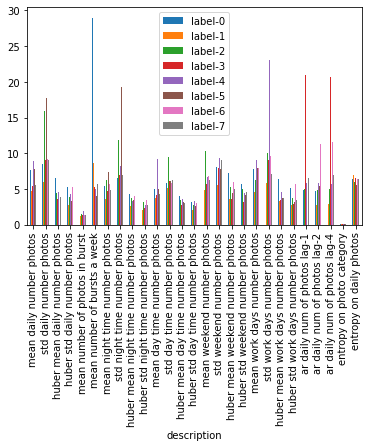

In [356]:
plt.figure()
df_med.plot.bar()

In [264]:
#del df_lbl5['labels']
#dflbl4 = srlbl4.to_frame()
#dflbl4.rename(columns = {0:'lvl-4'})

In [269]:
excel = df0.to_excel('csv_files/photo_gallery_yellow.xlsx')

In [ ]:
#read the tags from firebase json file for user register non register and create df with tag column
def create_tag_df(f): # 'entries.json'
    tag_data = json.load(codecs.open(f, 'r', 'utf-8-sig'))
    df_tag = pd.DataFrame(tag_data)
    df_tag = df_tag.rename(columns={'app_userid': ''})
    dftag = df_tag.set_index('')
    return dftag

In [ ]:
dftag = create_tag_df('entries.json')

In [ ]:
dfjoin = df.join(dftag)

In [ ]:
len(dfjoin)

In [ ]:
dfjoin['User_Register'] = dfjoin['User_Register'].fillna('false')
len(dfjoin[dfjoin.User_Register == 'false'])

In [ ]:
dfjoin.to_csv('csv_files/taged_aggresive_photogallery.csv')

In [ ]:
dfjoin.head(5)

In [ ]:
#sns.scatterplot('population', 'Area', data=df, hue='continent')
#sns.lmplot('population', 'Area', data=df, hue='continent', fit_reg=False)
plt.figure(figsize=(10,8))
sns.lmplot(
    x='x_col', 
    y='y_col',
    data=dfjoin,
    hue='User_Register',
    fit_reg=False,
    height=8,
)
plt.show()

--> tSNE for 3D

In [ ]:
tsne_3d = TSNE(n_components=3, verbose=1, perplexity=40, n_iter=300, method='exact')

In [ ]:
nz.shape

In [ ]:
tsne_res_3 = tsne_3d.fit_transform(nz)

In [ ]:
df3 = pd.DataFrame(tsne_res_3, columns=['x_col', 'y_col', 'z_col'], index=inxs)

In [ ]:
df3.head(5)

In [ ]:
ax = plt.figure(figsize=(16,10)).gca(projection='3d')
plt.axis()
ax.scatter(
    xs = df3['x_col'],
    ys = df3['y_col'],
    zs = df3['z_col'],
    cmap='tab2'
)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_xlim(-10, 10)
ax.set_ylim(-10, 10)
ax.set_zlim(-12, 12)
plt.show()

In [ ]:
bw = estimate_bandwidth(df3, quantile=0.2, n_samples=200)

In [ ]:
ms = MeanShift(bandwidth=bw, bin_seeding=True)
ms.fit(df3)

In [ ]:
labels = ms.labels_
cluster_centers = ms.cluster_centers_
labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)

In [ ]:
cluster_centers

In [ ]:
fig = plt.figure()
ax = plt.figure(figsize=(16,10)).gca(projection='3d')
ax.view_init(45, 180)
plt.axis()
X = df3.values
colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters_), colors):
    my_members = labels == k
    cluster_center = cluster_centers[k]
    plt.plot(X[my_members, 0], X[my_members, 1], X[my_members, 2], col + '.')
    plt.plot(cluster_center[0], cluster_center[1], cluster_center[2], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14)
plt.title('Estimated number of 3D clusters: %d' % n_clusters_)
plt.show()

In [ ]:
dfj3 = df3.join(dftag)
dfj3['User_Register'] = dfj3['User_Register'].fillna('false')
dfj3['User_Register'] = dfj3['User_Register'].map({'true': 'blue', 'false': 'red'})

In [ ]:
len(dfj3[dfj3.User_Register == 'blue'])

In [ ]:
%matplotlib inline
#%matplotlib notebook

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
#ax = plt.figure(figsize=(16,10)).gca(projection='3d')
fig = plt.figure()
ax = Axes3D(plt.figure(figsize=(10,8)))
ax.view_init(45, 180)
plt.axis()
ax.scatter(
    xs = dfj3['x_col'],
    ys = dfj3['y_col'],
    zs = dfj3['z_col'],
    c=dfj3['User_Register'],
    cmap='coolwarm'
)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_xlim(-12, 12)
ax.set_ylim(-12, 12)
ax.set_zlim(-12, 12)
plt.show()

In [ ]:
type(ax)